In [115]:
import pandas as pd
from datetime import datetime
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt

In [116]:
window_sizes = [32, 64, 128, 256, 512, 1024] # 512 is around minute
contamination_factors = [0.01, 0.02, 0.03, 0.04, 0.05]

In [117]:
df = pd.read_csv("data/finnhub2h.csv")
columns = ["price", "volume", "trade_ts"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda x: datetime.strptime(x, timestamp_format))
df = df.set_index("trade_ts")

size_of_df = len(df)

In [118]:
print(df.describe())
print(df.info())

              price        volume
count   58419.00000  58419.000000
mean   101381.63425      0.016505
std       356.57938      0.068510
min    100530.07000      0.000010
25%    101110.26000      0.000240
50%    101428.01000      0.000980
75%    101700.00000      0.005990
max    101898.00000      6.602400
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58419 entries, 2024-12-06 20:15:19.022000+00:00 to 2024-12-06 21:46:38.768000+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   58419 non-null  float64
 1   volume  58419 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB
None


C:\Users\seksc\AppData\Local\Temp\ipykernel_12260\2605485204.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['anomaly'] = clf.predict(test_features)  # -1 for anomalies, 1 for normal
C:\Users\seksc\AppData\Local\Temp\ipykernel_12260\2605485204.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['anomaly'] = test_df['anomaly'].map({1: 0, -1: 1})  # Convert to binary (1=anomaly, 0=normal)
C:\Users\seksc\AppData\Local\Temp\ipykernel_12260\2605485204.py:28: SettingWithCopyWarning: 
A value

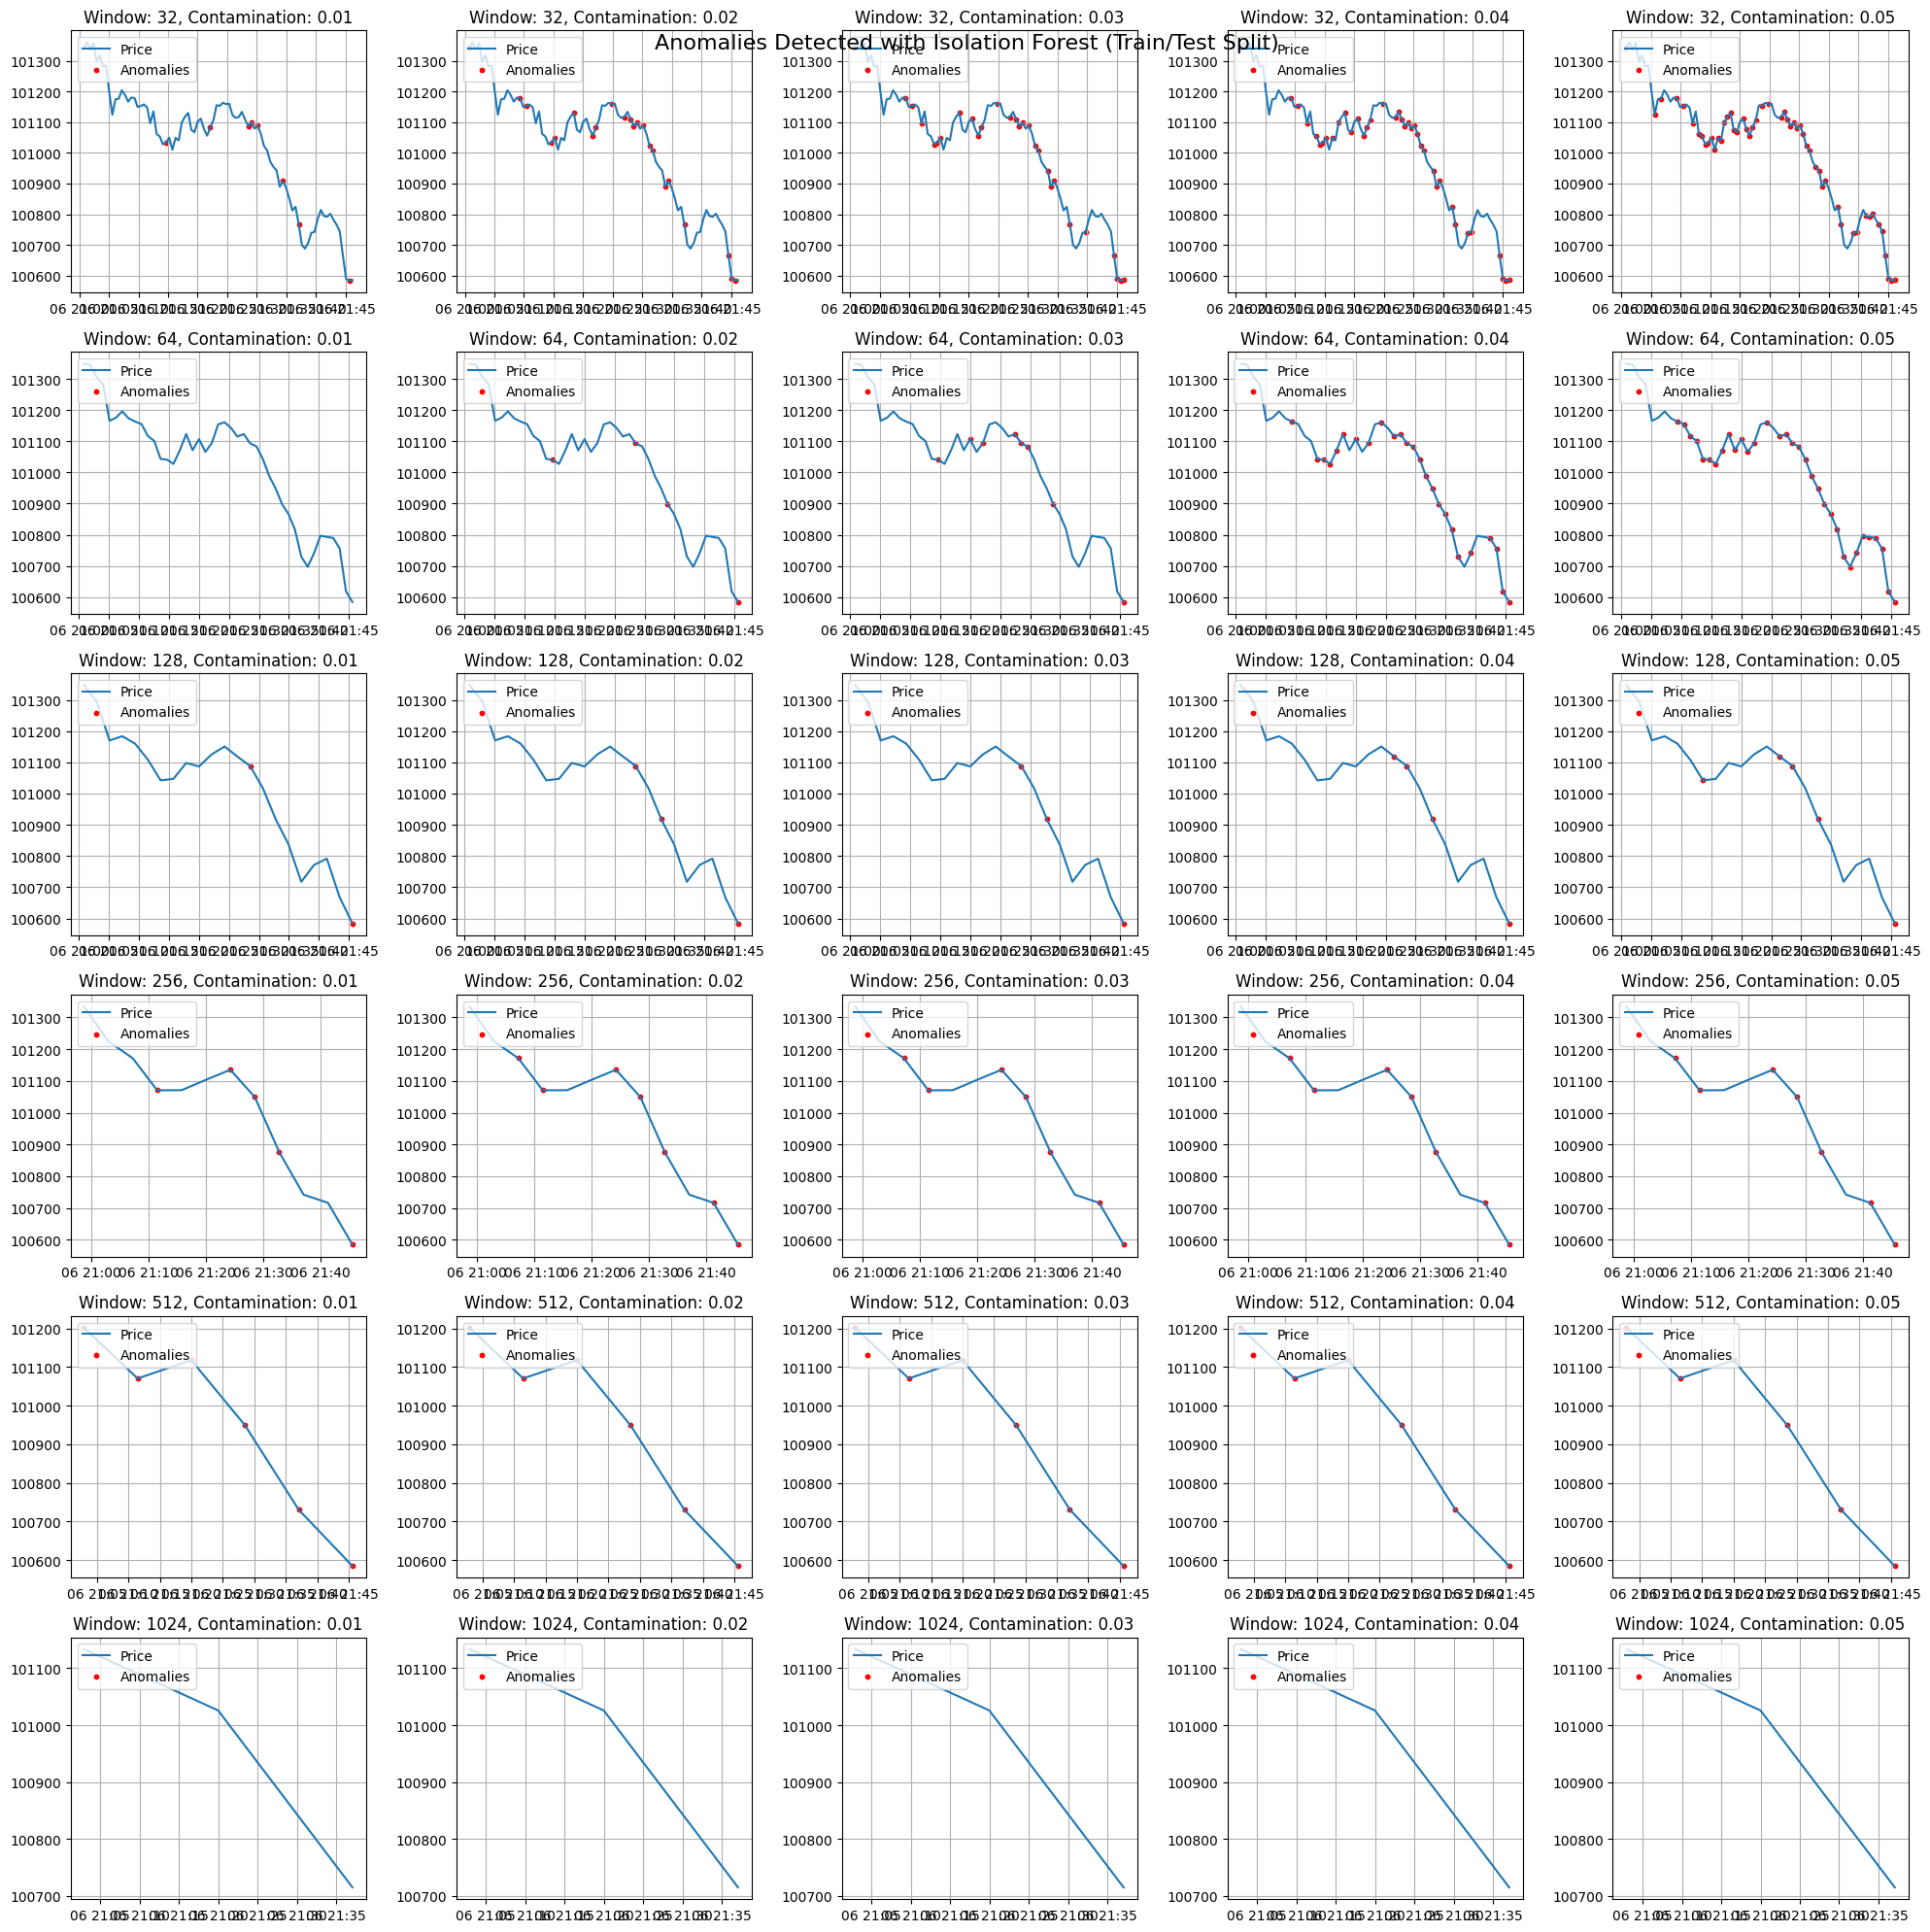

In [121]:
from sklearn.ensemble import IsolationForest

# Prepare for plotting
fig, axes = plt.subplots(len(window_sizes), len(contamination_factors), figsize=(20, 20), constrained_layout=True)

# Isolation Forest Anomaly Detection
for i, window in enumerate(window_sizes):
    for j, contamination in enumerate(contamination_factors):
        # Resample data to the current window size
        sampled_df = df.resample(f'{window}s').mean().dropna()  # Downsample by window in seconds

        # Split into training and testing
        split_point = len(sampled_df) // 2
        train_df = sampled_df.iloc[:split_point]
        test_df = sampled_df.iloc[split_point:]
        
        # Normalize the data (for both train and test)
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        train_features = scaler.fit_transform(train_df)
        test_features = scaler.transform(test_df)

        # Train Isolation Forest on the training window
        clf = IsolationForest(contamination=contamination, random_state=42)
        clf.fit(train_features)
        
        # Predict anomalies on the test window
        test_df['anomaly'] = clf.predict(test_features)  # -1 for anomalies, 1 for normal
        test_df['anomaly'] = test_df['anomaly'].map({1: 0, -1: 1})  # Convert to binary (1=anomaly, 0=normal)

        # Extract anomalies
        anomalies = test_df[test_df['anomaly'] == 1]

        # Plotting
        ax = axes[i, j]
        ax.plot(test_df.index, test_df['price'], label="Price")
        ax.scatter(anomalies.index, anomalies['price'], color='red', label="Anomalies", s=10)

        # Add titles and labels
        ax.set_title(f"Window: {window}, Contamination: {contamination}")
        ax.legend(loc="upper left")
        ax.grid(True)

# Finalize and show the plot
plt.tight_layout()
plt.suptitle("Anomalies Detected with Isolation Forest (Train/Test Split)", fontsize=16)
plt.show()